# Creating UXO like objects in SimPEG

In [209]:
from discretize import TensorMesh

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from SimPEG import maps

from SimPEG.utils import model_builder

## Defining a Tree Mesh

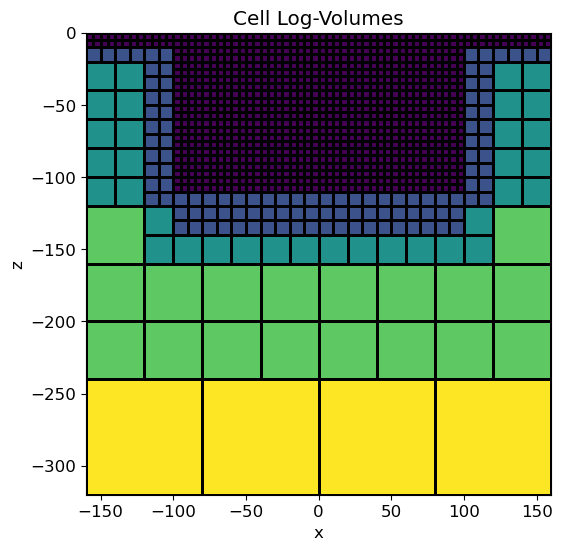

In [204]:
dx = 5  # minimum cell width (base mesh cell width) in x
dy = 5  # minimum cell width (base mesh cell width) in y
dz = 5  # minimum cell width (base mesh cell width) in z

x_length = 300.0  # domain width in x
y_length = 300.0  # domain width in y
z_length = 300.0  # domain width in y

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine surface topography
padding_surface = [[0, 0, 1]]
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = np.zeros(np.shape(xx))
topo_xyz = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

mesh.refine_surface(topo_xyz, padding_cells_by_level=padding_surface, finalize=False)

# Refine core mesh region
padding = [[0, 0, 2], [0, 0, 2]]
xp, yp, zp = np.meshgrid([-100.0, 100.0], [-100.0, 100.0], [-100.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh.refine_bounding_box(xyz, padding_cells_by_level=padding, finalize=False)
mesh.finalize()

# The bottom west corner
x0 = mesh.x0

# The total number of cells
nC = mesh.nC

# An (nC, 3) array containing the cell-center locations
cc = mesh.gridCC

# A boolean array specifying which cells lie on the boundary
bInd = mesh.cell_boundary_indices

# Cell volumes
v = mesh.cell_volumes

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mesh.plot_slice(np.log10(v), normal="Y", ax=ax, ind=int(mesh.h[1].size/2), grid=True)
ax.set_title("Cell Log-Volumes")
plt.show()

In [205]:
background_conductivity = 1
block_conductivity = 1000

ind_active = active_from_xyz(mesh, topo_xyz)
model = background_conductivity * np.ones(ind_active.sum())

cylinder_center = [0, 0, -60]  # Center of the cylinder
cylinder_axis = [0, 1, 0]      # Axis direction (vector)
cylinder_radius = 30           # Radius of the cylinder
cylinder_length = 120           # Length of the cylinder

num_points = 15
angle = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

top_circle = [
    cylinder_center + np.array([cylinder_radius * np.cos(a), cylinder_length / 2, cylinder_radius * np.sin(a)])
    for a in angle
]
bottom_circle = [
    cylinder_center + np.array([cylinder_radius * np.cos(a), -cylinder_length / 2, cylinder_radius * np.sin(a)])
    for a in angle
]

pts = np.vstack([top_circle, bottom_circle])

cylinder_inds = model_builder.polygonInd(mesh=mesh, pts=pts)
model[cylinder_inds] = block_conductivity

C:\Users\sabri\AppData\Local\Temp\ipykernel_4148\1649179008.py:26: FutureWarning: polygonInd has been deprecated, please use get_indices_polygon. It will be removed in version 0.19.0 of SimPEG.
  cylinder_inds = model_builder.polygonInd(mesh=mesh, pts=pts)


<Figure size 700x600 with 0 Axes>

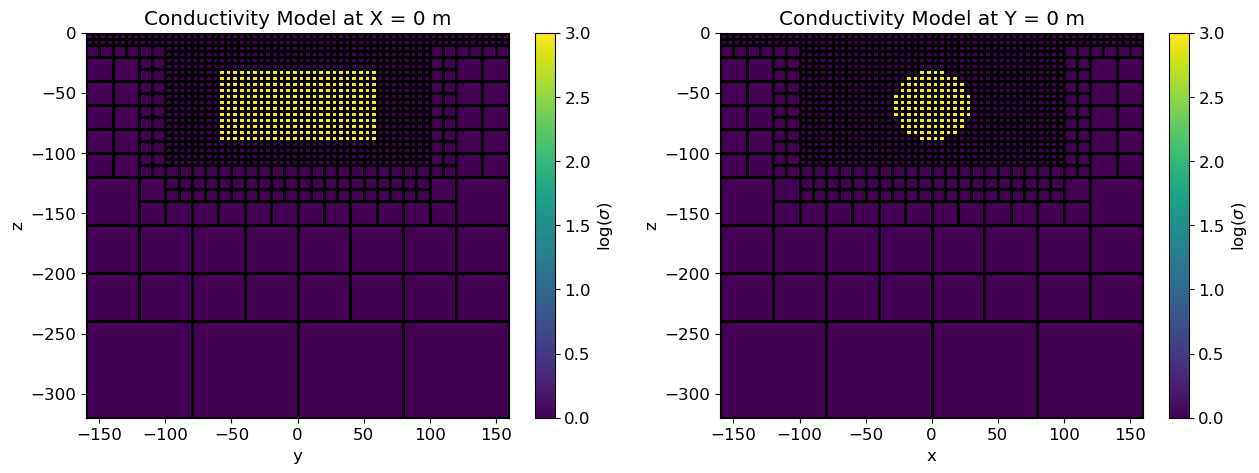

In [206]:
# Plot log-conductivity model
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 6))

log_model = np.log10(model)

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
plot_1 = mesh.plot_slice(
    plotting_map * log_model,
    normal="X",
    ax=ax1,
    ind=int(mesh.h[0].size / 2),
    grid=True,
    clim=(np.min(log_model), np.max(log_model)),
)

plot_2 = mesh.plot_slice(
    plotting_map * log_model,
    normal="Y",
    ax=ax2,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(log_model), np.max(log_model)),
)

norm = mpl.colors.Normalize(vmin=np.min(log_model), vmax=np.max(log_model))
ax1.set_title("Conductivity Model at X = 0 m")
cb = plt.colorbar(plot_1[0], ax=ax1, norm=norm, orientation="vertical")
cb.set_label(r"$\log(\sigma)$")

ax2.set_title("Conductivity Model at Y = 0 m")
cb = plt.colorbar(plot_2[0], ax=ax2, norm=norm, orientation="vertical")
cb.set_label(r"$\log(\sigma)$")

plt.show()

## Tensor Mesh

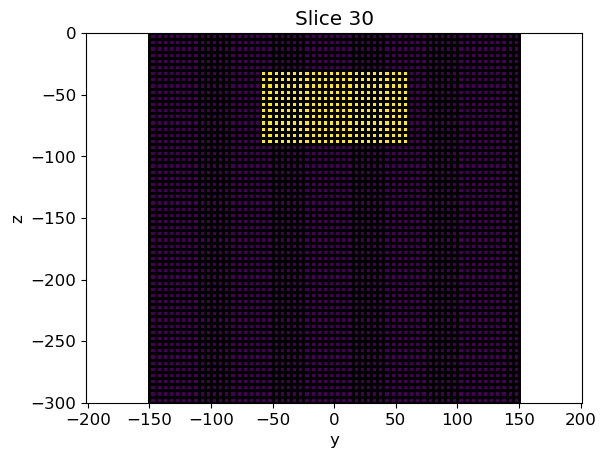

In [236]:
# Define parameters for the rectangular mesh
nx, ny, nz = int(x_length/dx), int(y_length/dy), int(z_length/dz)  # Number of cells in x, y, z directions
hx = [(dx, nx)]  # Cell widths in x
hy = [(dy, ny)]   # Cell widths in y
hz = [(dz, nz)]   # Cell widths in z

# Create the rectangular 3D mesh
mesh = TensorMesh([hx, hy, hz], x0="CCN")

# Create a model with the cylinder in the middle
model = np.zeros(mesh.nC)  # Initialize the model (e.g., background value zero)

# Mark cells within the cylinder radius as a different value
for i, cell_center in enumerate(mesh.cell_centers):
    x, y, z = cell_center

    if (y > cylinder_center[1] - cylinder_length/2) and (y < cylinder_center[1] + cylinder_length/2):
        if np.sqrt((x - cylinder_center[0])**2 + (z - cylinder_center[2])**2) <= cylinder_radius:
            model[i] = 1  # Set cells within the cylinder to 1 (or any other value)


# fig, ax = plt.subplots(figsize=(5, 5))
# mesh.plot_image(model, normal='Y', ind=int(ny/ 2), grid=True, ax=ax)
# ax.set_title("Cross-section of the Rectangular Mesh with Cylinder in the Center")
# plt.show()

ax = mesh.plot_slice(model, normal='X', grid=True, ind=30)
plt.axis('equal')
plt.show()